In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2

In [12]:
# Definisikan ukuran gambar dan direktori data
image_size = 299
data_dir = "data/Brain Tumor MRI Dataset/"
labels = ["glioma", "notumor", "meningioma", "pituitary"]

In [13]:
def load_images(directory, image_size):
    X = []
    y = []

    for label in labels:
        folderPath = os.path.join(directory, label)
        for filename in os.listdir(folderPath):
            img = cv2.imread(os.path.join(folderPath, filename))
            img = cv2.resize(img, (image_size, image_size))
            X.append(img)
            y.append(label)

    return np.array(X), np.array(y)

In [14]:
X, y = load_images(os.path.join(data_dir, "Training"), image_size)
X_test, y_test = load_images(os.path.join(data_dir, "Testing"), image_size)

In [15]:
X = np.concatenate((X, X_test), axis=0)
y = np.concatenate((y, y_test), axis=0)

In [16]:
X, y = shuffle(X, y, random_state=42)

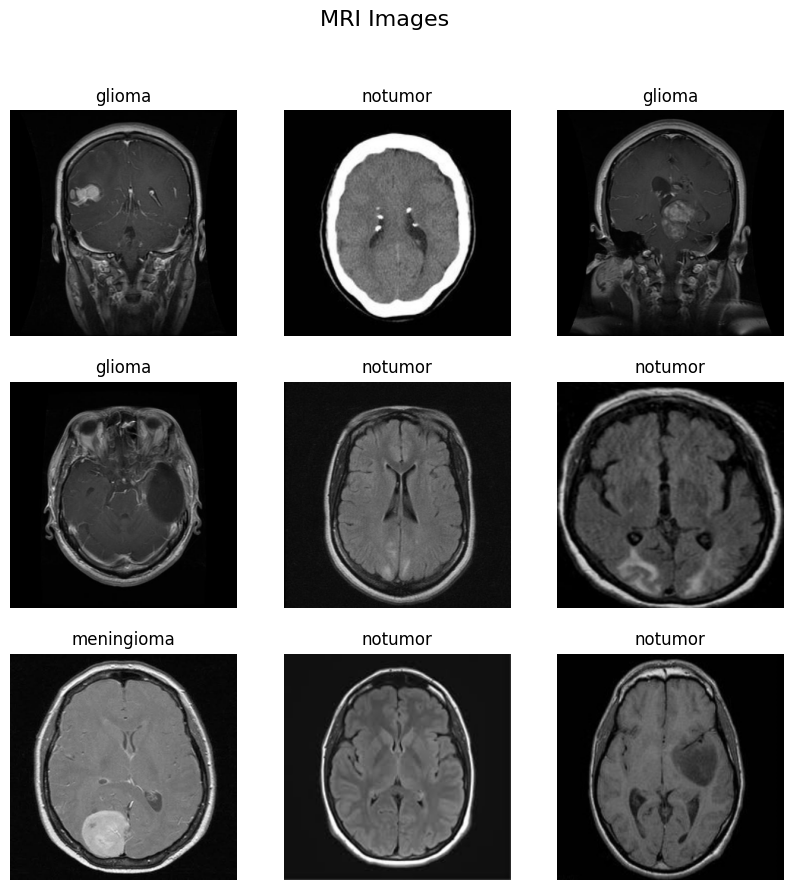

In [17]:
def visualize_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    plt.suptitle(title, fontsize=16)

    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(labels[i])
        plt.axis('off')

    plt.show()

visualize_images(X, y, 'MRI Images')

In [18]:
y = tf.keras.utils.to_categorical([labels.index(label) for label in y])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [20]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_datagen.fit(X_train)

In [22]:
xception_model = Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

for layer in xception_model.layers:
    layer.trainable = False

2024-05-30 19:13:56.253594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 19:13:56.475103: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 33s 0us/step


In [23]:
model = keras.Sequential([
    xception_model,
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Dense(4, activation="softmax")
])

In [24]:
model.compile(optimizer=Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [25]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train) // 32,
                    epochs=50,
                    validation_data=(X_test, y_test))

Epoch 1/50


2024-05-30 19:14:55.996320: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 419430400 exceeds 10% of free system memory.
2024-05-30 19:14:56.204101: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 419430400 exceeds 10% of free system memory.
2024-05-30 19:14:57.112537: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 419430400 exceeds 10% of free system memory.
2024-05-30 19:14:57.598661: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 419430400 exceeds 10% of free system memory.
2024-05-30 19:14:57.848281: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 419430400 exceeds 10% of free system memory.
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_q

11/11 ━━━━━━━━━━━━━━━━━━━━ 146s 11s/step - accuracy: 0.2672 - loss: 24.7390 - val_accuracy: 0.4000 - val_loss: 6.2108
Epoch 2/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:43 10s/step - accuracy: 0.2500 - loss: 13.9382

2024-05-30 19:17:27.967078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2500 - loss: 13.9382 - val_accuracy: 0.5500 - val_loss: 2.5773
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 120s 10s/step - accuracy: 0.4419 - loss: 8.7134 - val_accuracy: 0.7750 - val_loss: 1.9786
Epoch 4/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:26 9s/step - accuracy: 0.5625 - loss: 4.3038

2024-05-30 19:19:47.211999: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 878ms/step - accuracy: 0.5625 - loss: 4.3038 - val_accuracy: 0.8000 - val_loss: 1.8144
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 111s 10s/step - accuracy: 0.6520 - loss: 5.0469 - val_accuracy: 0.8500 - val_loss: 2.4033
Epoch 6/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:34 9s/step - accuracy: 0.6562 - loss: 3.3688

2024-05-30 19:21:56.254268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6562 - loss: 3.3688 - val_accuracy: 0.8000 - val_loss: 2.3104
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 113s 10s/step - accuracy: 0.6821 - loss: 2.6859 - val_accuracy: 0.8750 - val_loss: 1.5860
Epoch 8/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:34 9s/step - accuracy: 0.6562 - loss: 2.1830

2024-05-30 19:24:08.980561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.6562 - loss: 2.1830 - val_accuracy: 0.8750 - val_loss: 1.6706
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 128s 12s/step - accuracy: 0.7135 - loss: 1.8638 - val_accuracy: 0.8500 - val_loss: 1.1108
Epoch 10/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:40 10s/step - accuracy: 0.9062 - loss: 0.6458

2024-05-30 19:26:37.574825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9062 - loss: 0.6458 - val_accuracy: 0.8500 - val_loss: 1.1200
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 121s 11s/step - accuracy: 0.7343 - loss: 1.6076 - val_accuracy: 0.8250 - val_loss: 0.9694
Epoch 12/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:27 9s/step - accuracy: 0.8125 - loss: 0.6621

2024-05-30 19:28:57.642049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 985ms/step - accuracy: 0.8125 - loss: 0.6621 - val_accuracy: 0.8500 - val_loss: 0.9416
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 114s 10s/step - accuracy: 0.7663 - loss: 0.9647 - val_accuracy: 0.8500 - val_loss: 0.6878
Epoch 14/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:31 9s/step - accuracy: 0.8125 - loss: 0.7778

2024-05-30 19:31:10.772713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8125 - loss: 0.7778 - val_accuracy: 0.8500 - val_loss: 0.7265
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - accuracy: 0.7729 - loss: 0.8982 - val_accuracy: 0.8750 - val_loss: 0.5736
Epoch 16/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:17 8s/step - accuracy: 0.7188 - loss: 0.5928

2024-05-30 19:33:11.237597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 855ms/step - accuracy: 0.7188 - loss: 0.5928 - val_accuracy: 0.9000 - val_loss: 0.5538
Epoch 17/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 101s 9s/step - accuracy: 0.7798 - loss: 0.6667 - val_accuracy: 0.8750 - val_loss: 0.6976
Epoch 18/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.8750 - loss: 0.5495

2024-05-30 19:35:03.936286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 788ms/step - accuracy: 0.8750 - loss: 0.5495 - val_accuracy: 0.8000 - val_loss: 0.6630
Epoch 19/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 98s 8s/step - accuracy: 0.7986 - loss: 0.7377 - val_accuracy: 0.8500 - val_loss: 0.5457
Epoch 20/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:19 8s/step - accuracy: 0.7812 - loss: 0.5935

2024-05-30 19:36:57.813237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 16s 843ms/step - accuracy: 0.7812 - loss: 0.5935 - val_accuracy: 0.8500 - val_loss: 0.5900
Epoch 21/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 110s 10s/step - accuracy: 0.7792 - loss: 0.6829 - val_accuracy: 0.8500 - val_loss: 0.5558
Epoch 22/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:31 9s/step - accuracy: 0.8750 - loss: 0.5417

2024-05-30 19:39:05.640843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 952ms/step - accuracy: 0.8750 - loss: 0.5417 - val_accuracy: 0.8500 - val_loss: 0.5392
Epoch 23/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 113s 10s/step - accuracy: 0.8290 - loss: 0.5061 - val_accuracy: 0.8250 - val_loss: 0.7290
Epoch 24/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:37 10s/step - accuracy: 0.6250 - loss: 0.6855

2024-05-30 19:41:18.215178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 999ms/step - accuracy: 0.6250 - loss: 0.6855 - val_accuracy: 0.8250 - val_loss: 0.7538
Epoch 25/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 108s 9s/step - accuracy: 0.8081 - loss: 0.6075 - val_accuracy: 0.9500 - val_loss: 0.4390
Epoch 26/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:26 9s/step - accuracy: 0.7812 - loss: 0.5150

2024-05-30 19:43:24.621609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 974ms/step - accuracy: 0.7812 - loss: 0.5150 - val_accuracy: 0.9500 - val_loss: 0.4217
Epoch 27/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 112s 10s/step - accuracy: 0.8445 - loss: 0.4626 - val_accuracy: 0.8750 - val_loss: 0.6052
Epoch 28/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:26 9s/step - accuracy: 0.8438 - loss: 0.4487

2024-05-30 19:45:34.990223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 917ms/step - accuracy: 0.8438 - loss: 0.4487 - val_accuracy: 0.8750 - val_loss: 0.6120
Epoch 29/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 115s 10s/step - accuracy: 0.8176 - loss: 0.5670 - val_accuracy: 0.8750 - val_loss: 0.5696
Epoch 30/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:46 11s/step - accuracy: 0.8750 - loss: 0.2885

2024-05-30 19:47:49.556586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8750 - loss: 0.2885 - val_accuracy: 0.8750 - val_loss: 0.5607
Epoch 31/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 113s 10s/step - accuracy: 0.8550 - loss: 0.5363 - val_accuracy: 0.9000 - val_loss: 0.6101
Epoch 32/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:25 9s/step - accuracy: 0.9062 - loss: 0.1959

2024-05-30 19:50:01.899010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 971ms/step - accuracy: 0.9062 - loss: 0.1959 - val_accuracy: 0.9000 - val_loss: 0.6787
Epoch 33/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 120s 11s/step - accuracy: 0.8131 - loss: 0.5149 - val_accuracy: 0.8000 - val_loss: 0.7224
Epoch 34/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.8750 - loss: 0.5015

2024-05-30 19:52:15.587619: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 966ms/step - accuracy: 0.8750 - loss: 0.5015 - val_accuracy: 0.8000 - val_loss: 0.6886
Epoch 35/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 116s 10s/step - accuracy: 0.8130 - loss: 0.6097 - val_accuracy: 0.9250 - val_loss: 0.5230
Epoch 36/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:43 10s/step - accuracy: 0.8438 - loss: 0.5940

2024-05-30 19:54:31.153180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 20s 1000ms/step - accuracy: 0.8438 - loss: 0.5940 - val_accuracy: 0.9250 - val_loss: 0.5379
Epoch 37/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 120s 10s/step - accuracy: 0.8494 - loss: 0.4454 - val_accuracy: 0.9250 - val_loss: 0.5886
Epoch 38/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:33 9s/step - accuracy: 0.9062 - loss: 0.4515

2024-05-30 19:56:50.583334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 982ms/step - accuracy: 0.9062 - loss: 0.4515 - val_accuracy: 0.9250 - val_loss: 0.5951
Epoch 39/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 112s 10s/step - accuracy: 0.8783 - loss: 0.3253 - val_accuracy: 0.9250 - val_loss: 0.6988
Epoch 40/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:27 9s/step - accuracy: 0.7500 - loss: 0.5902

2024-05-30 19:59:01.337434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 18s 934ms/step - accuracy: 0.7500 - loss: 0.5902 - val_accuracy: 0.9250 - val_loss: 0.6792
Epoch 41/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 110s 10s/step - accuracy: 0.8601 - loss: 0.3938 - val_accuracy: 0.9500 - val_loss: 0.3823
Epoch 42/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:31 9s/step - accuracy: 0.7812 - loss: 0.4648

2024-05-30 20:01:09.417817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 976ms/step - accuracy: 0.7812 - loss: 0.4648 - val_accuracy: 0.9500 - val_loss: 0.3725
Epoch 43/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 113s 10s/step - accuracy: 0.8501 - loss: 0.4584 - val_accuracy: 0.9500 - val_loss: 0.5516
Epoch 44/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:32 9s/step - accuracy: 0.8125 - loss: 0.4164

2024-05-30 20:03:21.158465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 965ms/step - accuracy: 0.8125 - loss: 0.4164 - val_accuracy: 0.9500 - val_loss: 0.5692
Epoch 45/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 114s 10s/step - accuracy: 0.8601 - loss: 0.4711 - val_accuracy: 0.9250 - val_loss: 0.5546
Epoch 46/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:32 9s/step - accuracy: 0.8438 - loss: 0.4412

2024-05-30 20:05:34.185887: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 956ms/step - accuracy: 0.8438 - loss: 0.4412 - val_accuracy: 0.9250 - val_loss: 0.5577
Epoch 47/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 111s 10s/step - accuracy: 0.8780 - loss: 0.4275 - val_accuracy: 0.9250 - val_loss: 0.6319
Epoch 48/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:29 9s/step - accuracy: 0.8750 - loss: 0.3978

2024-05-30 20:07:44.116343: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 960ms/step - accuracy: 0.8750 - loss: 0.3978 - val_accuracy: 0.9250 - val_loss: 0.6537
Epoch 49/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 114s 10s/step - accuracy: 0.8857 - loss: 0.3552 - val_accuracy: 0.8750 - val_loss: 0.7478
Epoch 50/50
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1:33 9s/step - accuracy: 0.9375 - loss: 0.2285

2024-05-30 20:09:56.911448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 993ms/step - accuracy: 0.9375 - loss: 0.2285 - val_accuracy: 0.8500 - val_loss: 0.7671


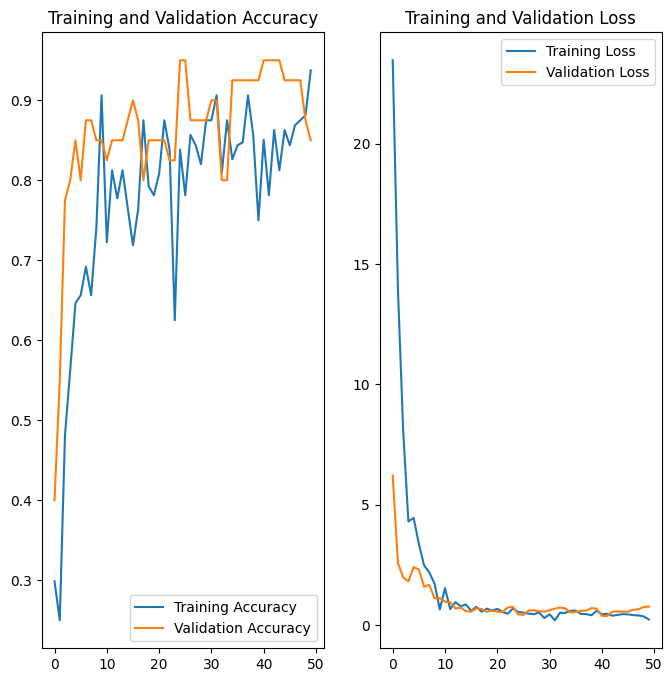

In [26]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
model.evaluate(X_test,y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8583 - loss: 0.7025


[0.767062246799469, 0.8500000238418579]

2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


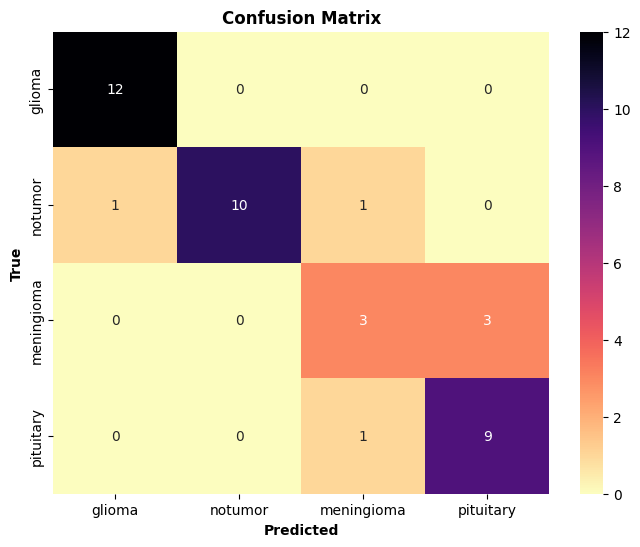

In [28]:
y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma_r', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontweight='bold')
plt.ylabel('True', fontweight='bold')
plt.title('Confusion Matrix', fontweight='bold')
plt.show()

In [29]:
def preprocess_image(image_path, image_size):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (image_size, image_size))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def predict_tumor_class(model, image_path, labels):
    image = preprocess_image(image_path, image_size)
    prediction = model.predict(image)
    predicted_class = labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    return predicted_class, confidence

In [30]:
image_path = "data/Brain Tumor MRI Dataset/Testing/pituitary/Te-pi_0031.jpg"
predicted_class, confidence = predict_tumor_class(model, image_path, labels)

print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Predicted Class: pituitary
Confidence: 100.00%


In [31]:
from keras.models import load_model

model.save('model.h5')